In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

Predefined functions; they should look familiar to functions you've coded in assignments!

In [3]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    """Return an array of all the residuals"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

Dataset for today:

In [12]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


# Lecture 26

## Regression Model

Ignore this code; it produces plots for demonstrating the regression model

In [4]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

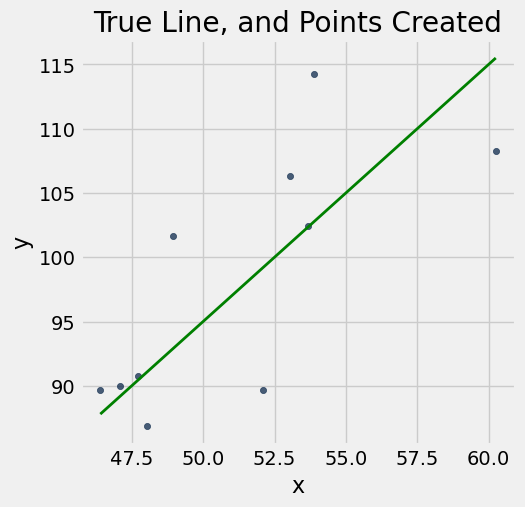

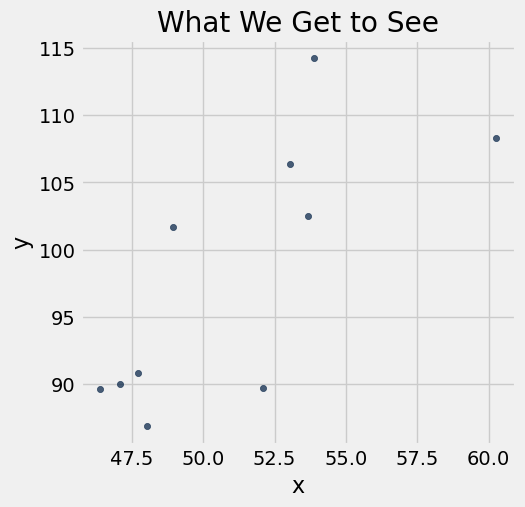

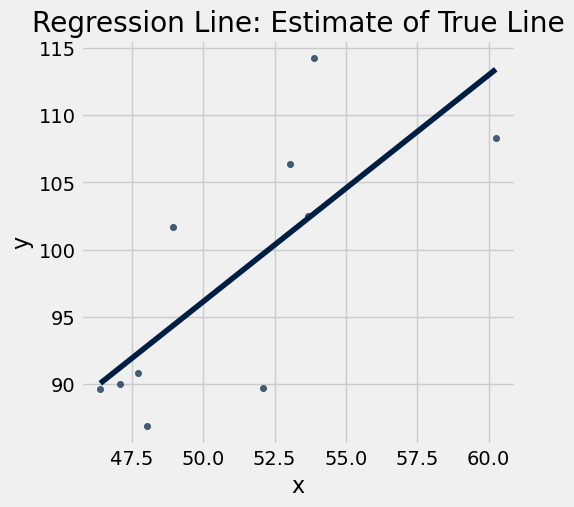

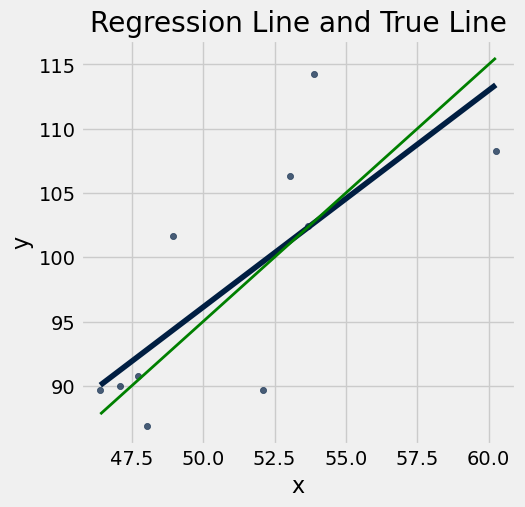

In [9]:
draw_and_compare(2, -5, 10)

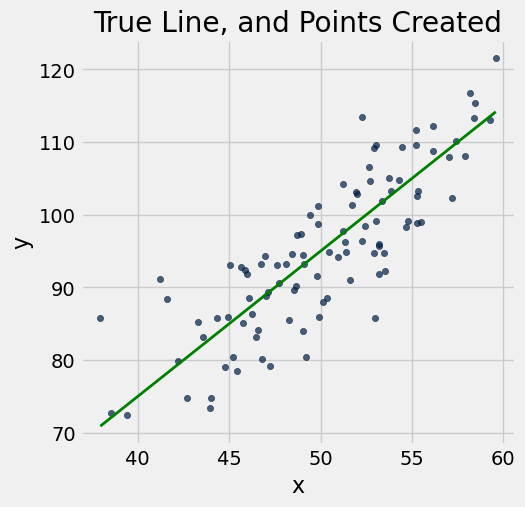

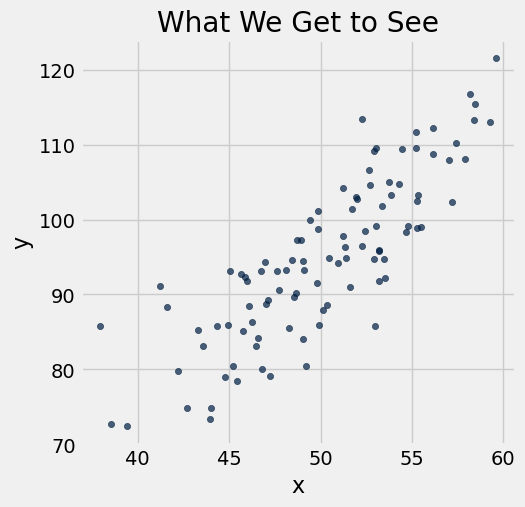

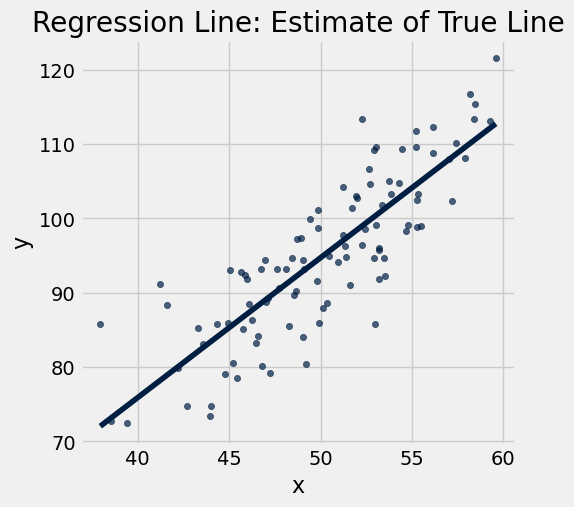

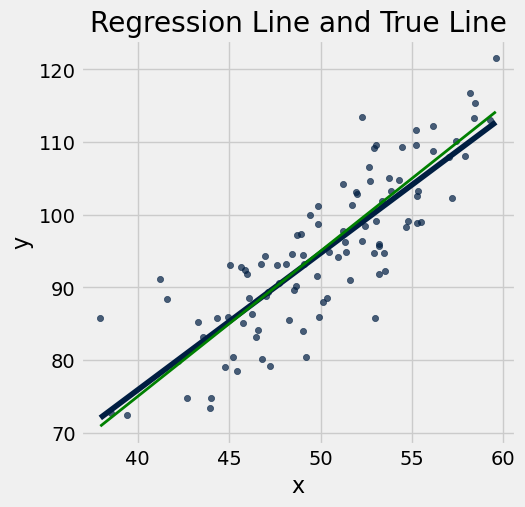

In [10]:
draw_and_compare(2, -5, 100)

Running each of these cells more than once shows how we can get different estimates of the line depending on the sample.

**STOP**

## Confidence Interval for True Slope

### Bootstrapping the Sample

You don't need to understand the plotting code in this cell, but you should understand the figure that comes out.

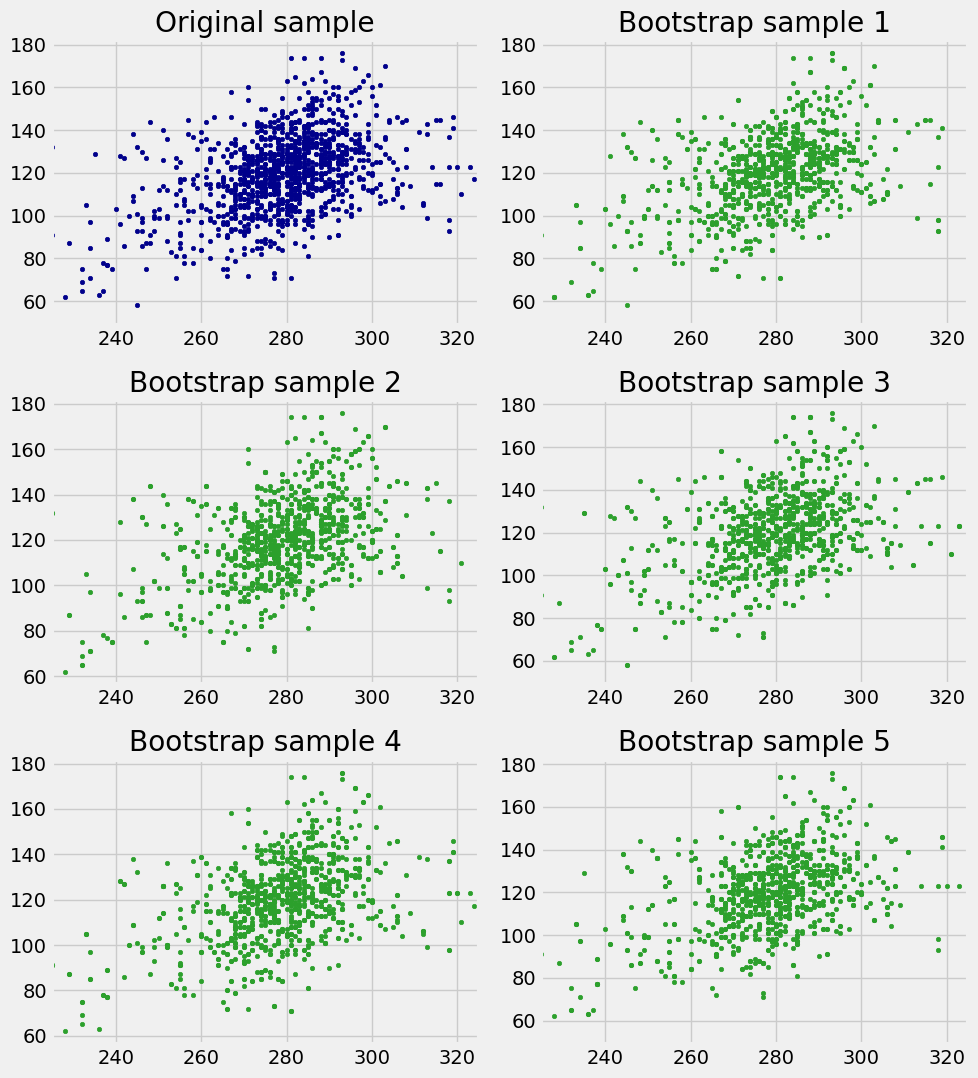

In [13]:
plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()

### Inference for the True Slope 

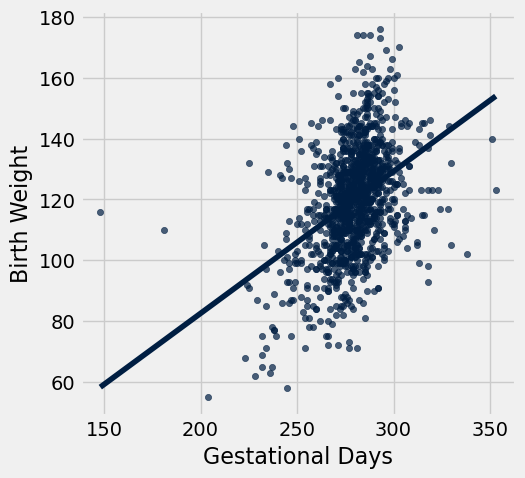

In [14]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [15]:
slope(births, 'Gestational Days', 'Birth Weight')

0.46655687694921522

**One bootstrap sample + function**

In [18]:
bootstrap_sample = births.sample()

In [20]:
bootstrap_slope = slope(bootstrap_sample, 'Gestational Days', 'Birth Weight')
bootstrap_slope

0.51068968507333412

This function also does some plotting, in addition to repeating the bootstrap process.

In [22]:
def bootstrap_slope(t, x, y, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the slope of the true line, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    round_left = round(left, 3)
    round_right = round(right, 3)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results (no need to follow this code)
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', round(observed_slope, 3))
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(round_left, 'to', round_right)

Slope of regression line: 0.467
Approximate 95%-confidence interval for the slope of the true line:
0.377 to 0.56


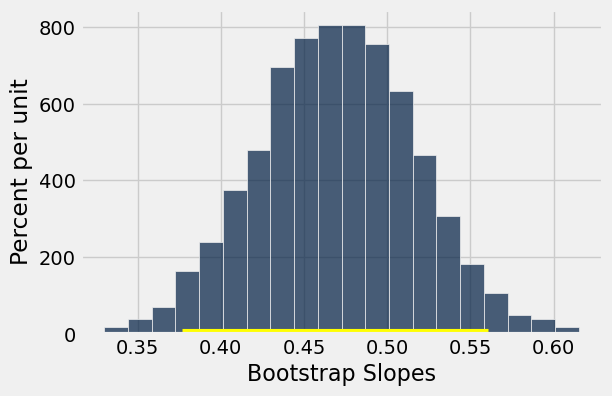

In [23]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight')

**STOP**

## Rain on the Regression Parade

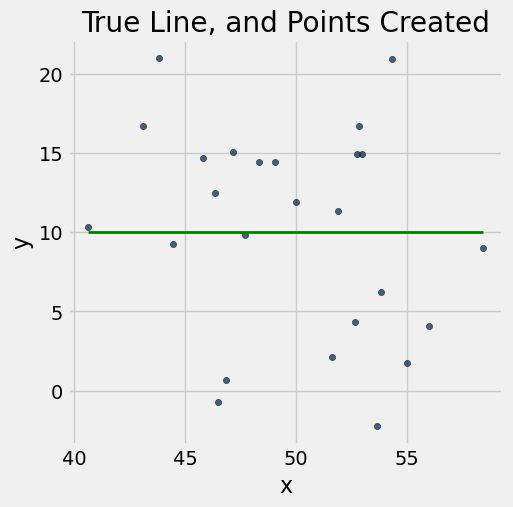

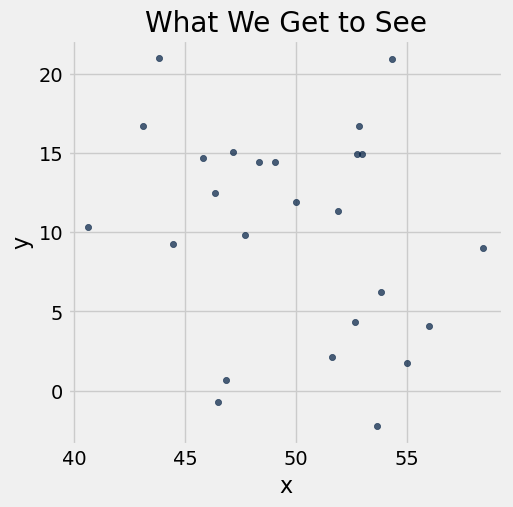

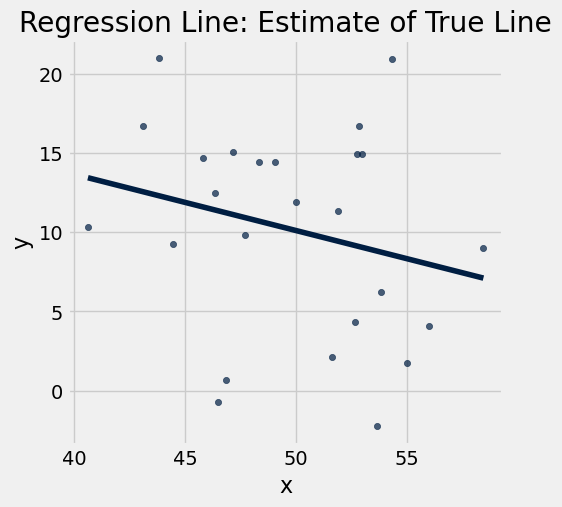

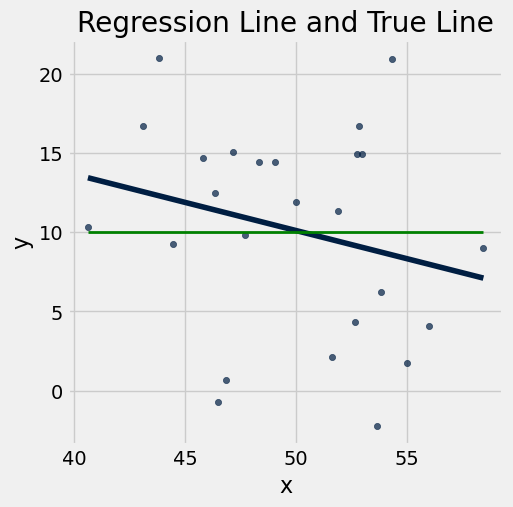

In [24]:
draw_and_compare(0, 10, 25)

**STOP**

## Test whether the slope has a trend

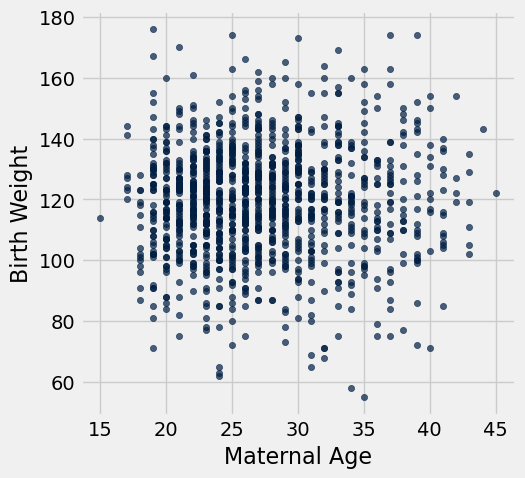

In [25]:
births.scatter('Maternal Age', 'Birth Weight')

In [26]:
slope(births, 'Maternal Age', 'Birth Weight')

0.085007669415825132

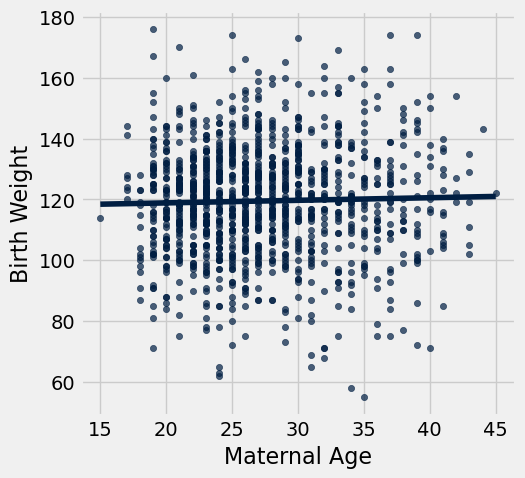

In [27]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

**Null:** Slope of true line is equal to 0.

**Alternative:** Slope of true line is not equal to 0.

Slope of regression line: 0.085
Approximate 95%-confidence interval for the slope of the true line:
-0.106 to 0.272


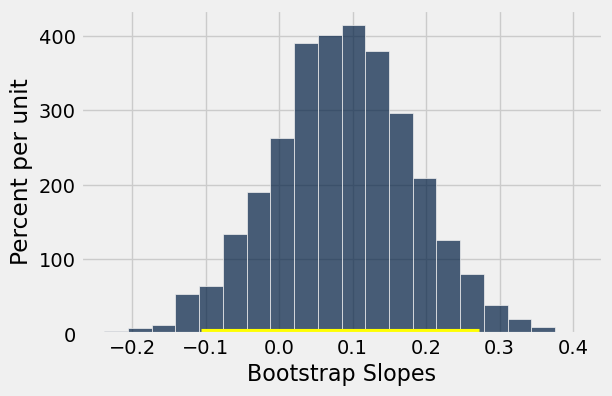

In [28]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight')

**STOP**

## Prediction Variability

Preterm and postterm pregnancy cutoffs, according to the CDC

In [30]:
37 * 7, 42 * 7

(259, 294)

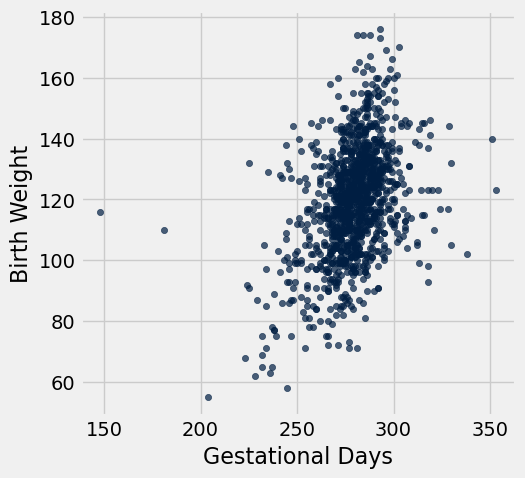

In [31]:
births.scatter('Gestational Days', 'Birth Weight')

In [32]:
births = births.where('Gestational Days', are.between(225, 325))

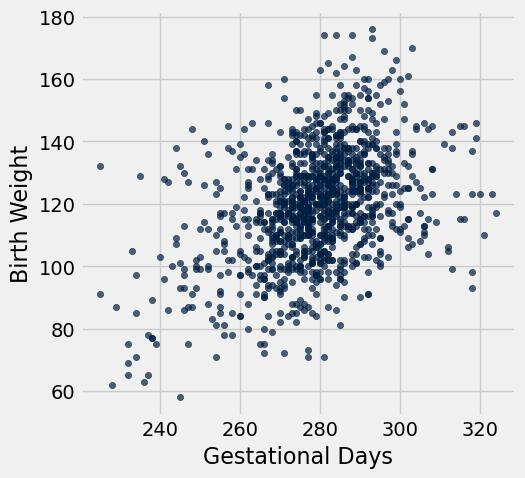

In [33]:
births.scatter('Gestational Days', 'Birth Weight')

### Suppose we assume the regression model. Then...

In [34]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.42295118452423991

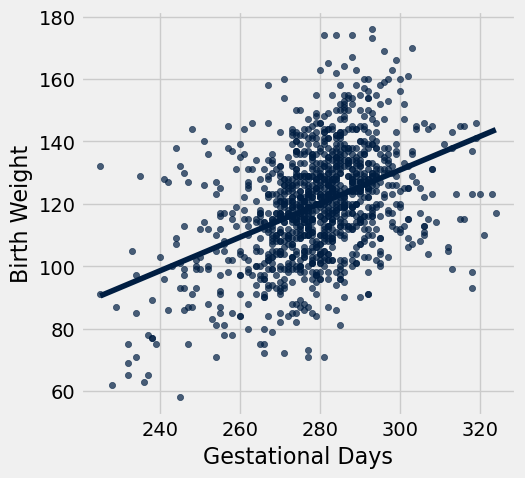

In [35]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

### Prediction at a given value of $x$

In [43]:
x_value = 300

In [44]:
slope(births, 'Gestational Days', 'Birth Weight')* x_value +  intercept(births, 'Gestational Days', 'Birth Weight')

130.80951674248769

In [36]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [41]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.80951674248769

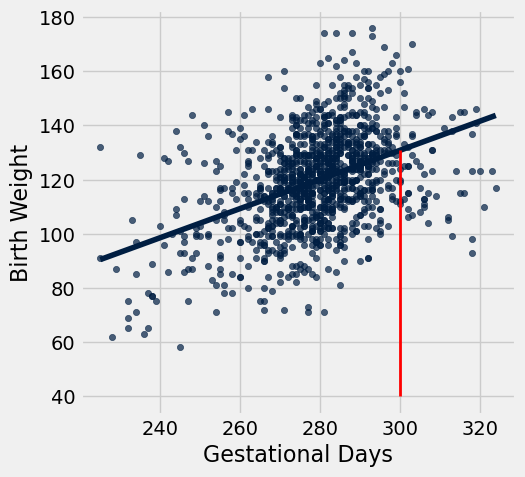

In [42]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2);

**Bootstrapping predictions**

Predicted y from bootstrap sample was 130.425893106
Predicted y from bootstrap sample was 132.199787779
Predicted y from bootstrap sample was 130.802604988
Predicted y from bootstrap sample was 130.26373056


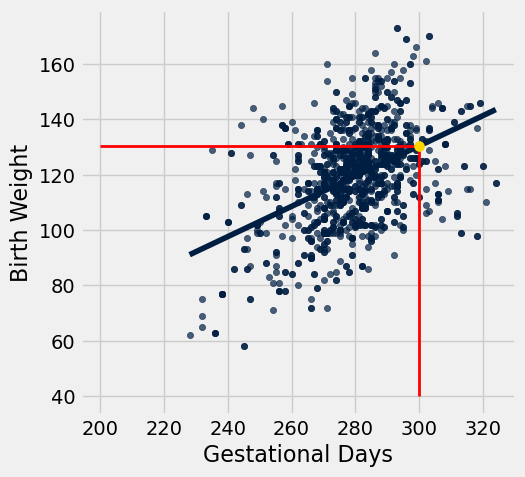

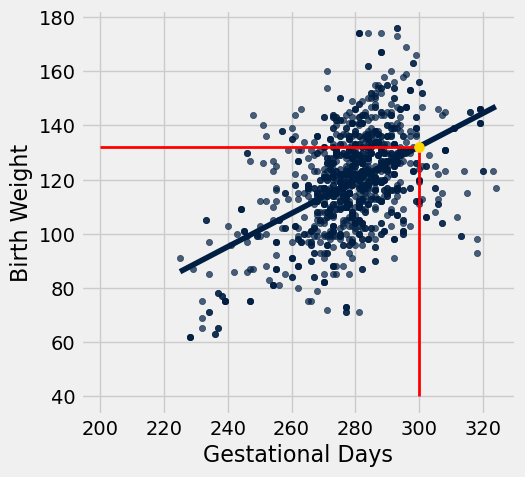

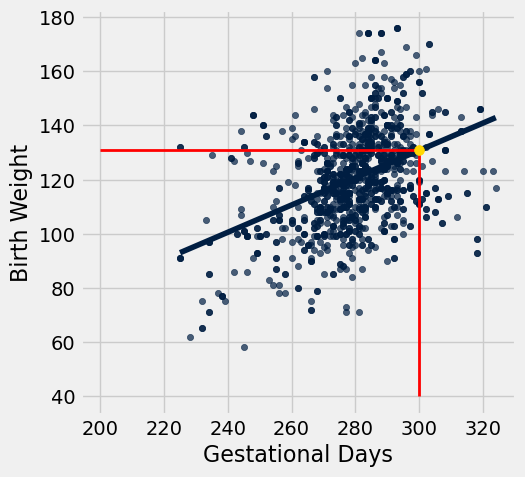

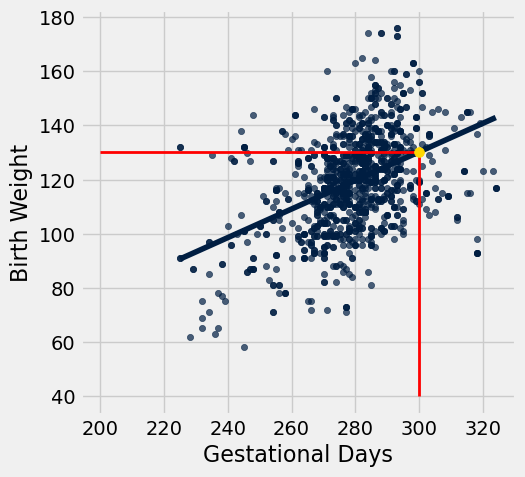

In [45]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstrap sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='red', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='red', lw=2);

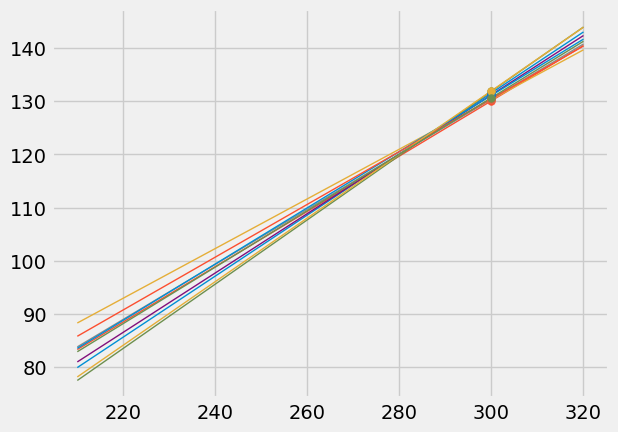

In [46]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

In [47]:
np.mean(births.column('Gestational Days')), np.mean(births.column('Birth Weight'))

(279.11015490533561, 119.57401032702238)

In [48]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
lines


slope,intercept,at 291,at 300,at 309
0.555806,-36.0091,125.73,130.733,135.735
0.511492,-22.5423,126.302,130.905,135.509
0.510883,-22.9202,125.747,130.345,134.943
0.52822,-27.226,126.486,131.24,135.994
0.573525,-39.9316,126.964,132.126,137.288
0.532517,-29.527,125.435,130.228,135.021
0.559352,-36.0982,126.673,131.707,136.742
0.596377,-45.353,128.193,133.56,138.927
0.444294,-4.60895,124.681,128.679,132.678
0.594032,-45.3927,127.471,132.817,138.163


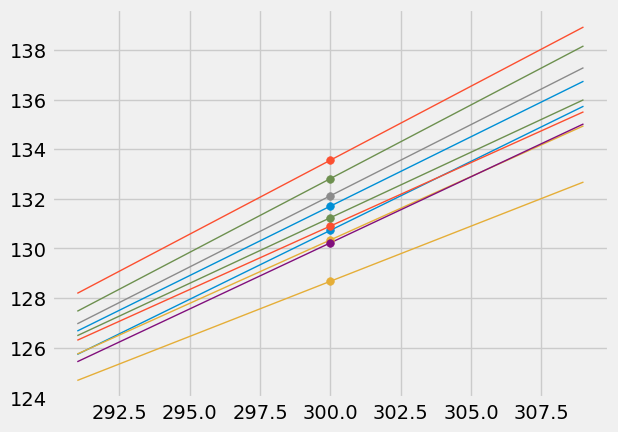

In [49]:
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

**STOP**

### Prediction Interval

In [58]:
bootstrap_sample = births.sample()

In [59]:
predicted_y = prediction_at(bootstrap_sample, 'Gestational Days', 'Birth Weight', 300)

In [60]:
predicted_y

130.71052543531749

In [52]:
def bootstrap_prediction(t, x, y, new_x, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the height of the true line at new_x, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    round_left = round(left, 3)
    round_right = round(right, 3)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line at x =', new_x)
    print(round_left, 'to', round_right, '( width =', round(right - left, 3), ')')

Approximate 95%-confidence interval for height of true line at x = 300
129.014 to 132.811 ( width = 3.797 )


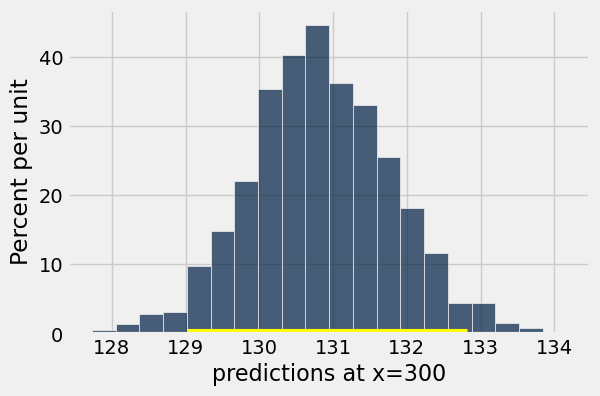

In [53]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

**STOP**

### Predictions at different values of $x$

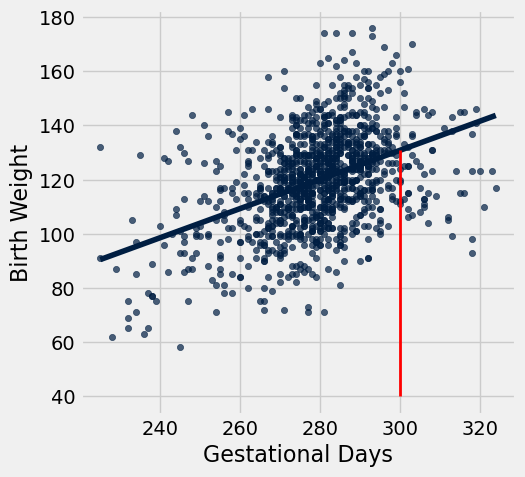

In [54]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2);

Approximate 95%-confidence interval for height of true line at x = 230
89.052 to 97.162 ( width = 8.109 )


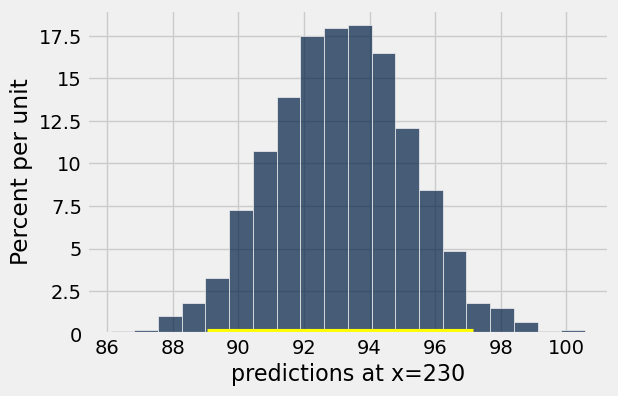

In [55]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 230)

Approximate 95%-confidence interval for height of true line at x = 280
119.152 to 120.957 ( width = 1.805 )


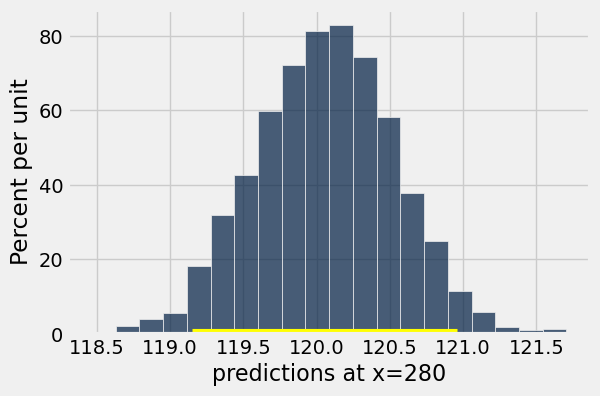

In [56]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

No need to follow the code in this cell; just understand the graph

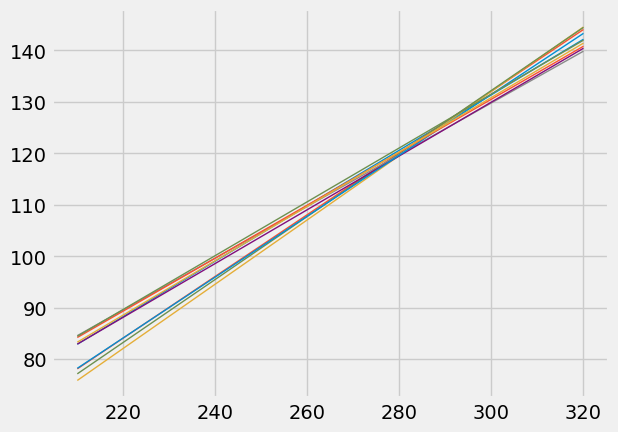

In [57]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)

**STOP**